In [1]:
#@title Packages

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import seaborn as sns
from scipy.stats import zscore
from scipy.stats import mstats
from scipy.stats import percentileofscore
from scipy.signal import savgol_filter
from scipy.signal import periodogram
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import joblib
import os
import warnings

In [2]:
#@title Basic Information

stock_data = pd.read_csv("../Data/dataset3.csv")

In [3]:
#@title Remove the First 2 Months

stock_data = stock_data[stock_data['Date'] >= '2020-06-01']

print(f"Number of Observations and Columns: {stock_data.shape}")
print(f"Number of stocks: {stock_data['Symbol'].nunique()}")
print("Variables:")
for column in stock_data.columns:
    print(column)

Number of Observations and Columns: (735475, 26)
Number of stocks: 403
Variables:
Date
Open
High
Low
Close
Volume
Symbol
SMA
EMA
MACD
ADX
PSAR
RSI
ROC
SOK
MOM
WILLR
TRIX
CMO
SD
OBV
AD
MFI
CCI
BOP
BB


In [4]:
#@title Missing Values

nan_counts = stock_data.apply(lambda x: x.isnull().sum())
nan_counts = nan_counts[nan_counts > 0]
print(nan_counts)

Series([], dtype: int64)


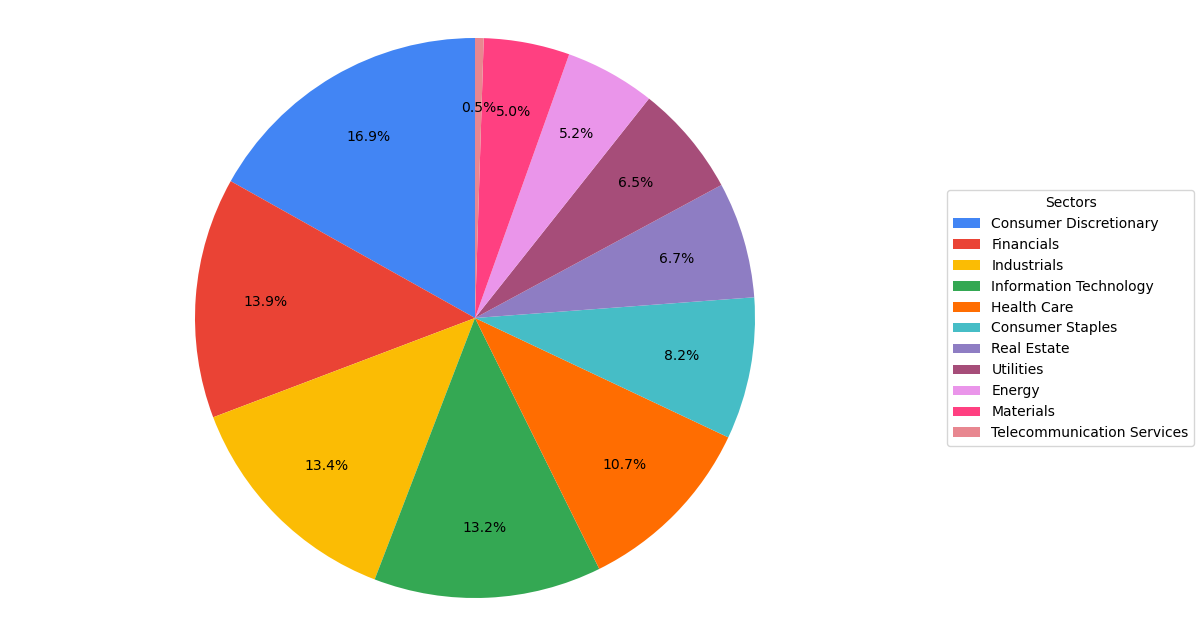

In [6]:
#@title Pie Chart with the Sectors

sp500 = pd.read_csv("../Data/sp500.csv")
stock_data_2 = stock_data.merge(sp500[['Symbol', 'Sector']], on='Symbol', how='left')
stock_data_unique = stock_data_2[['Symbol', 'Sector']].drop_duplicates(subset='Symbol').copy()
sector_counts = stock_data_unique['Sector'].value_counts()

strong_colors = ['#4285f4', '#ea4335', '#fbbc04', '#34a853', '#ff6d01', '#46bdc6', '#8e7dc3', '#a64d79', '#ea95ea', '#ff4081', '#e88790']
plt.figure(figsize=(12, 8))
wedges, texts, autotexts = plt.pie(sector_counts, autopct='%1.1f%%', startangle=90, colors=strong_colors[:len(sector_counts)], pctdistance=0.75)
plt.legend(wedges, sector_counts.index, title="Sectors", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.axis('equal')
plt.show()

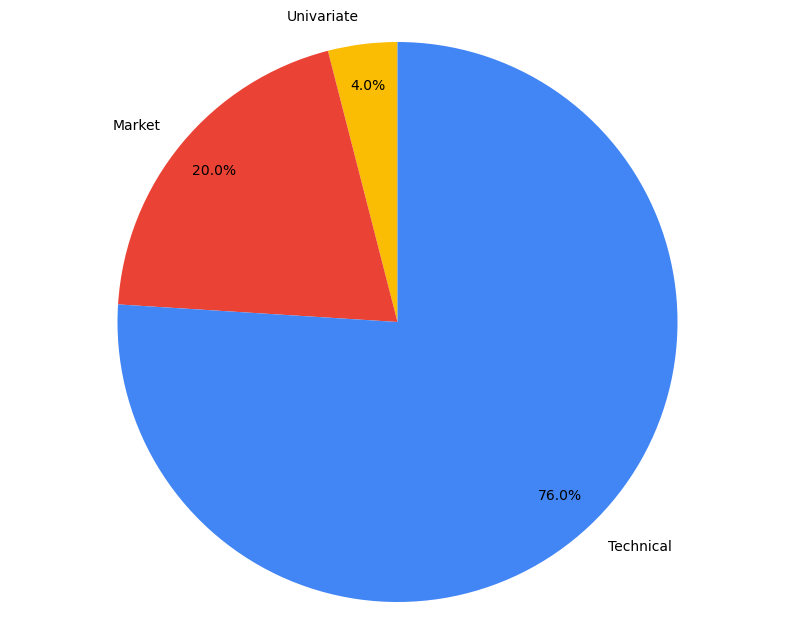

In [6]:
#@title Pie Chart with the Variables per Category

categories = ['Univariate', 'Market', 'Technical']
values = [1, 5, 19]
strong_colors = ['#fbbc04', '#ea4335','#4285f4']

plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(values, labels=categories, autopct='%1.1f%%', startangle=90, colors=strong_colors, pctdistance=0.85, labeldistance=1.1)
plt.axis('equal')
plt.show()

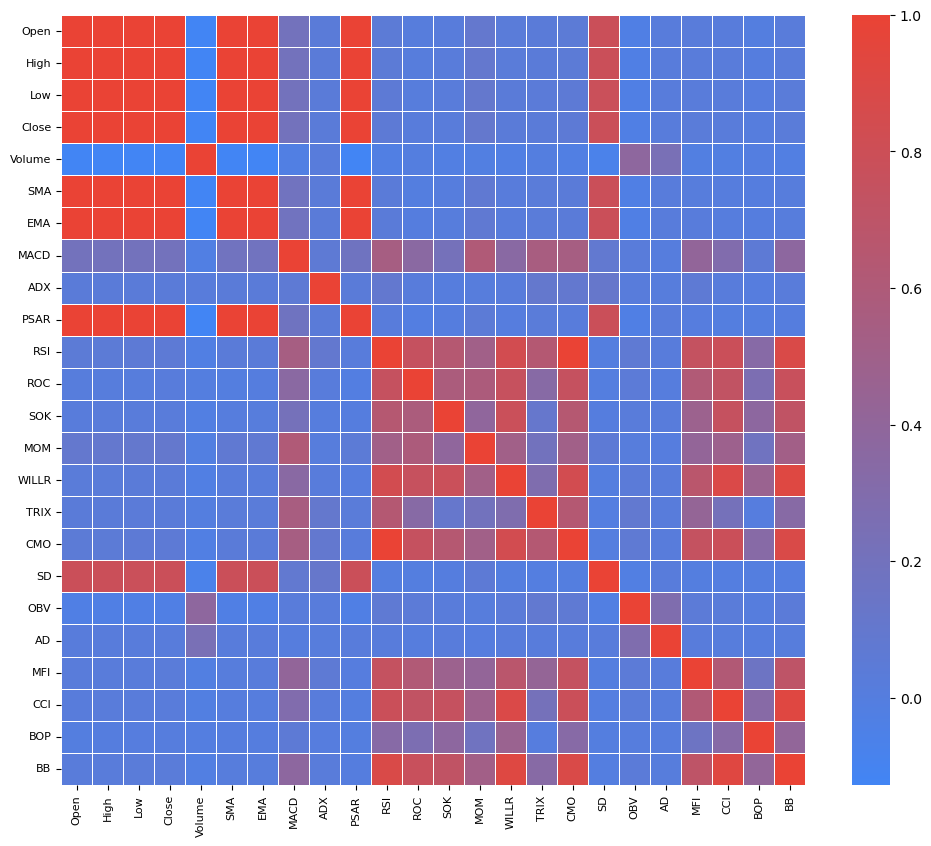

In [7]:
#@title Correlation Between Variables

custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_cmap", ['#4285f4', '#ea4335']
)

stock_data2 = stock_data.drop(columns=['Symbol', 'Date'])
corr_matrix = stock_data2.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap=custom_cmap,
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={"orientation": "vertical"}
)

plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

ax = plt.gca()
ax.tick_params(axis='x', which='both', bottom=True, top=False)
ax.spines['top'].set_visible(False)

plt.show()

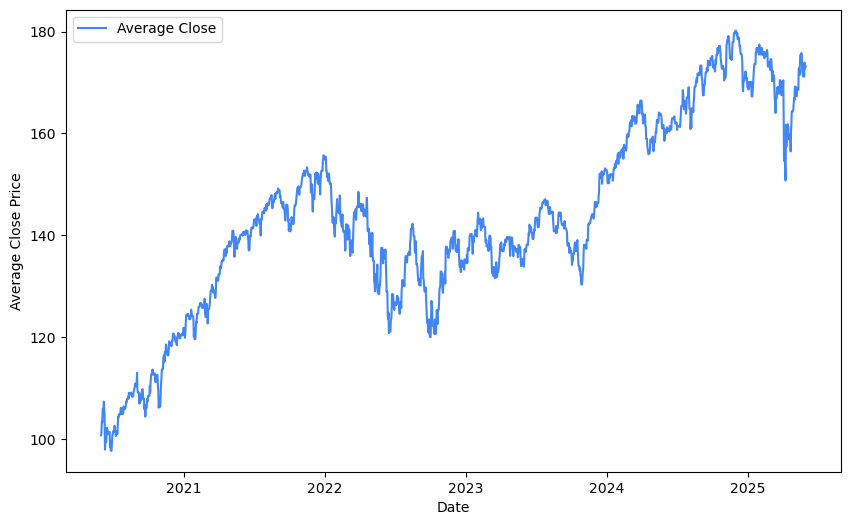

In [8]:
#@title Price through Time (Average Close Price for All Stocks)

stock_data['Date'] = pd.to_datetime(stock_data['Date'])
average_close = stock_data.groupby('Date')['Close'].mean()
plt.figure(figsize=(10, 6))
plt.plot(average_close, label='Average Close', color='#4285f4')
plt.xlabel('Date')
plt.ylabel('Average Close Price')
plt.legend()
plt.show()

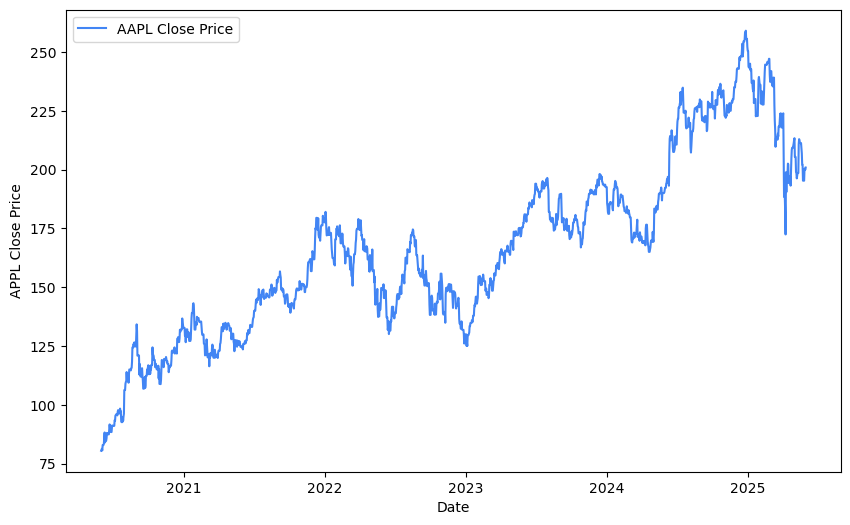

In [9]:
#@title Price through Time (AAPL Close Price)

aapl_data = stock_data[stock_data['Symbol'] == 'AAPL']
plt.figure(figsize=(10,6))
plt.plot(aapl_data['Date'], aapl_data['Close'], label='AAPL Close Price', color='#4285f4')
plt.xlabel('Date')
plt.ylabel('APPL Close Price')
plt.legend()
plt.show()

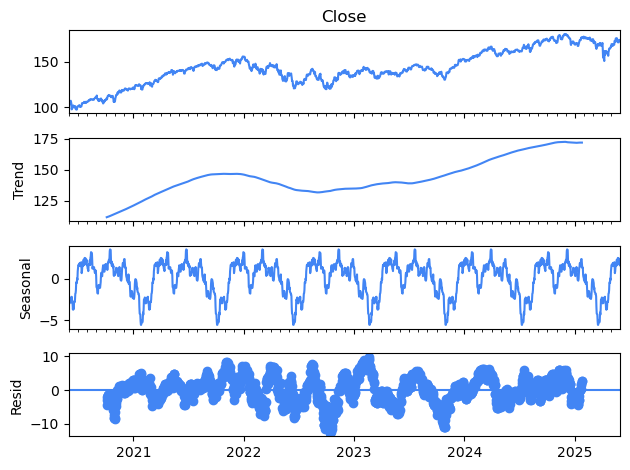

In [10]:
#@title Seasonal Decompose (Average Close Price for All Stocks)

stock_data['Date'] = pd.to_datetime(stock_data['Date'])
avg_close = stock_data.groupby('Date')['Close'].mean().sort_index()
result = seasonal_decompose(avg_close, model='additive', period=252)

fig = result.plot()

for ax in fig.axes:
    for line in ax.get_lines():
        line.set_color('#4285f4')

ax = fig.axes[-1]  
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.tick_params(axis='x', which='minor', bottom=False, labelbottom=False)
plt.setp(ax.get_xticklabels(), rotation=0, ha='center')

plt.show()

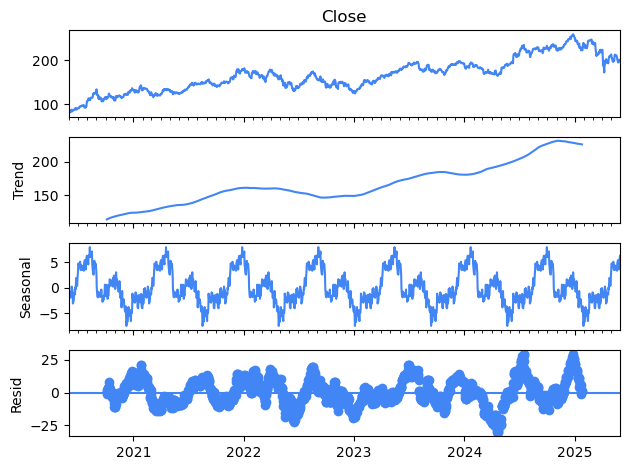

In [11]:
#@title Seasonal Decompose (AAPL Close Price)

stock_data['Date'] = pd.to_datetime(stock_data['Date'])
aapl_data = stock_data[stock_data['Symbol'] == 'AAPL']
aapl_close = aapl_data.groupby('Date')['Close'].mean().sort_index()

result = seasonal_decompose(aapl_close, model='additive', period=252)

fig = result.plot()

for ax in fig.axes:
    for line in ax.get_lines():
        line.set_color('#4285f4')

ax = fig.axes[-1]

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.tick_params(axis='x', which='minor', bottom=False, labelbottom=False)
plt.setp(ax.get_xticklabels(), rotation=0, ha='center')
plt.show()

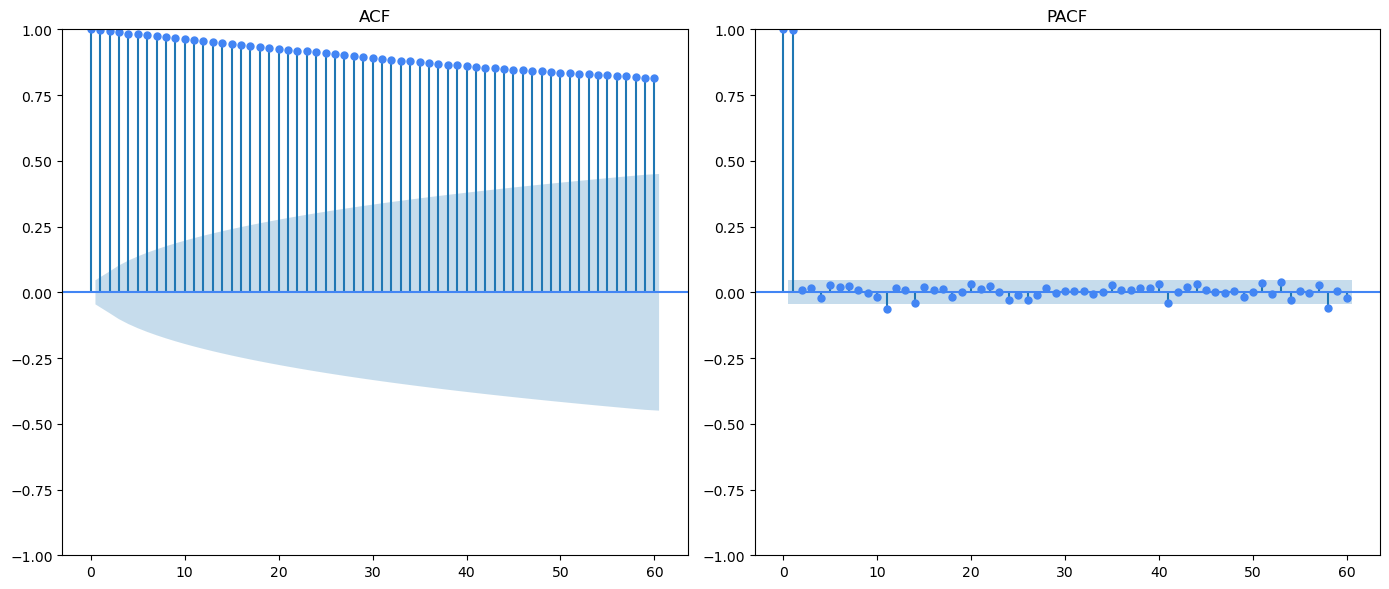

In [12]:
#@title ACF and PACF (Average Close Price for All Stocks)

stock_data['Date'] = pd.to_datetime(stock_data['Date'])
avg_close = stock_data.groupby('Date')['Close'].mean().sort_index()

plt.figure(figsize=(14, 6))

ax1 = plt.subplot(1, 2, 1)
plot_acf(avg_close, ax=ax1, lags=60)
plt.title('ACF')

ax2 = plt.subplot(1, 2, 2)
plot_pacf(avg_close, ax=ax2, lags=60)
plt.title('PACF')

for ax in [ax1, ax2]:
    for line in ax.lines:  
        line.set_color('#4285f4')
    for patch in ax.patches:  
        patch.set_facecolor('#4285f4')

plt.tight_layout()
plt.show()

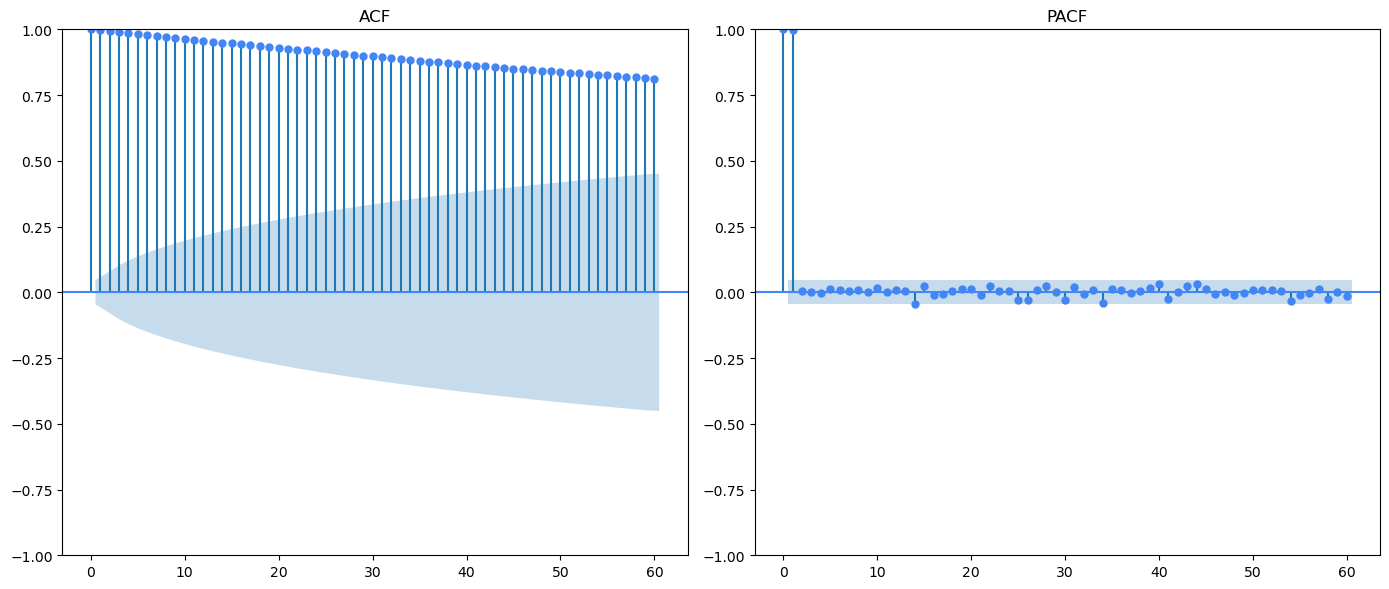

In [13]:
#@title ACF and PACF (AAPL Close Price)

aapl_data = stock_data[stock_data['Symbol'] == 'AAPL'].copy()
aapl_data['Date'] = pd.to_datetime(aapl_data['Date'])
aapl_close = aapl_data.groupby('Date')['Close'].mean().sort_index()

plt.figure(figsize=(14, 6))

ax1 = plt.subplot(1, 2, 1)
plot_acf(aapl_close, ax=ax1, lags=60)
plt.title('ACF')

ax2 = plt.subplot(1, 2, 2)
plot_pacf(aapl_close, ax=ax2, lags=60)
plt.title('PACF')

for ax in [ax1, ax2]:
    for line in ax.lines:  
        line.set_color('#4285f4')
    for patch in ax.patches:  
        patch.set_facecolor('#4285f4')

plt.tight_layout()
plt.show()

In [14]:
#@title Extract Characteristics for each Symbol

characteristics = []

for symbol, df_sym in stock_data.groupby("Symbol"):
    df_sym = df_sym.sort_values("Date").copy()
    
    latest_close = df_sym["Close"].iloc[-1]
    latest_volume = df_sym["Volume"].iloc[-1]
    years = (df_sym["Date"].iloc[-1] - df_sym["Date"].iloc[0]).days / 365
    cagr = (df_sym["Close"].iloc[-1] / df_sym["Close"].iloc[0]) ** (1 / years) - 1
    daily_returns = df_sym["Close"].pct_change().dropna()
    vol_5y = daily_returns.std()
    try:
        decomposition = seasonal_decompose(df_sym["Close"], period=365, model='additive', extrapolate_trend='freq')
        seasonality_strength = np.var(decomposition.seasonal) / np.var(df_sym["Close"])
    except:
        seasonality_strength = np.nan
    sharpe_5y = (daily_returns.mean() / daily_returns.std()) if daily_returns.std() != 0 else np.nan
    cum_return = (1 + daily_returns).cumprod()
    peak = cum_return.cummax()
    max_drawdown = ((cum_return - peak) / peak).min()

    characteristics.append({
        "Symbol": symbol,
        "Price": latest_close,
        "Volume": latest_volume,
        "Growth": cagr,
        "Volatility": vol_5y,
        "Seasonality": seasonality_strength,
        "Sharpe Ratio": sharpe_5y,
        "Max Drawdown": max_drawdown
    })

stocks_characteristics = pd.DataFrame(characteristics).reset_index(drop=True)
stocks_characteristics.to_csv('../Data/stocks_characteristics.csv', index=False)

normalized_df = stocks_characteristics.copy()
numeric_cols = normalized_df.select_dtypes(include=["number"]).columns
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_df[numeric_cols] = scaler.fit_transform(normalized_df[numeric_cols])
normalized_df.to_csv('../Data/stocks_characteristics_norm.csv', index=False)

In [15]:
#@title Analyze Characteristics for each Symbol - PART 1

variables = ['Price', 'Volume', 'Growth', 'Volatility', 'Seasonality', 'Sharpe Ratio', 'Max Drawdown']

for column in variables:
    print(f"\n{'='*50}")
    print(f"{column.upper()}")
    print(f"{'='*50}")
    
    print(f"\nTop 5 HIGHEST {column}:")
    print("-" * 30)
    top_max = stocks_characteristics.nlargest(5, column)[['Symbol', column]]
    for idx, row in top_max.iterrows():
        print(f"{row['Symbol']:>8}: {row[column]:>12.4f}")
    
    print(f"\nTop 5 LOWEST {column}:")
    print("-" * 30)
    top_min = stocks_characteristics.nsmallest(5, column)[['Symbol', column]]
    for idx, row in top_min.iterrows():
        print(f"{row['Symbol']:>8}: {row[column]:>12.4f}")


PRICE

Top 5 HIGHEST Price:
------------------------------
     AZO:    3733.0400
     TDG:    1468.4300
    NFLX:    1207.2300
     MTD:    1155.5200
     GWW:    1087.5600

Top 5 LOWEST Price:
------------------------------
     XRX:       4.8900
    COTY:       4.9300
     HBI:       4.9500
     NWL:       5.3000
      UA:       6.3000

VOLUME

Top 5 HIGHEST Volume:
------------------------------
    NVDA: 333170851.0000
       F: 152191621.0000
    INTC: 114281897.0000
    AAPL: 70819942.0000
     WBA: 69213728.0000

Top 5 LOWEST Volume:
------------------------------
     AZO:  190985.0000
     AMG:  281328.0000
     MTD:  317154.0000
     GWW:  360822.0000
     TDG:  374972.0000

GROWTH

Top 5 HIGHEST Growth:
------------------------------
    NVDA:       0.7270
     PWR:       0.5533
    AVGO:       0.5290
      GE:       0.4881
     SIG:       0.4409

Top 5 LOWEST Growth:
------------------------------
     VFC:      -0.2651
    ILMN:      -0.2538
     WBA:      -0.2364
     L

In [16]:
#@title Analyze Characteristics for each Symbol - PART 2

summary_stats = stocks_characteristics.describe()
print(summary_stats)

             Price        Volume      Growth  Volatility  Seasonality  \
count   403.000000  4.030000e+02  403.000000  403.000000   403.000000   
mean    173.143077  9.246145e+06    0.096649    0.016740     0.042200   
std     261.503746  2.118446e+07    0.134446    0.004995     0.037103   
min       4.890000  1.909850e+05   -0.265080    0.008832     0.002125   
25%      54.600000  2.206349e+06    0.014828    0.013116     0.016819   
50%      96.280000  4.305224e+06    0.091859    0.015616     0.030170   
75%     208.595000  9.167400e+06    0.177627    0.019173     0.055915   
max    3733.040000  3.331709e+08    0.726972    0.035623     0.247936   

       Sharpe Ratio  Max Drawdown  
count    403.000000    403.000000  
mean       0.023431     -0.459249  
std        0.019457      0.162265  
min       -0.032940     -0.904308  
25%        0.012289     -0.556320  
50%        0.024185     -0.434129  
75%        0.036781     -0.330407  
max        0.075002     -0.170940  


In [17]:
#@title Analyze Characteristics for AAPL

if 'AAPL' not in stocks_characteristics['Symbol'].values:
    print("AAPL not found in the dataset!")
else:
    variables = ['Price', 'Volume', 'Growth', 'Volatility', 'Seasonality', 'Sharpe Ratio', 'Max Drawdown']
    
    print(f"{'='*60}")
    print(f"{'AAPL RANKING ANALYSIS':^60}")
    print(f"{'='*60}")
    
    aapl_data = stocks_characteristics[stocks_characteristics['Symbol'] == 'AAPL'].iloc[0]
    
    for column in variables:
        print(f"\n{column.upper()}")
        print("-" * 40)
        
        aapl_value = aapl_data[column]
        percentile = percentileofscore(stocks_characteristics[column], aapl_value, kind='rank')
        rank = (stocks_characteristics[column] >= aapl_value).sum()
        total_stocks = len(stocks_characteristics)
        
        if column in ['Growth', 'Sharpe Ratio']:
            interpretation = "Higher is Better"
            performance = "EXCELLENT" if percentile >= 80 else "GOOD" if percentile >= 60 else "AVERAGE" if percentile >= 40 else "BELOW AVERAGE" if percentile >= 20 else "POOR"
        elif column in ['Volatility', 'Max Drawdown']:
            interpretation = "Lower is Better"
            performance = "EXCELLENT" if percentile <= 20 else "GOOD" if percentile <= 40 else "AVERAGE" if percentile <= 60 else "BELOW AVERAGE" if percentile <= 80 else "POOR"
        else:
            interpretation = "Context Dependent"
            performance = "NEUTRAL"
        
        print(f"AAPL Value: {aapl_value:>12.4f}")
        print(f"Rank: {rank:>6} out of {total_stocks} stocks")
        print(f"Percentile: {percentile:>8.1f}% ({interpretation})")
        print(f"Performance: {performance}")

                   AAPL RANKING ANALYSIS                    

PRICE
----------------------------------------
AAPL Value:     200.8500
Rank:    107 out of 403 stocks
Percentile:     73.7% (Context Dependent)
Performance: NEUTRAL

VOLUME
----------------------------------------
AAPL Value: 70819942.0000
Rank:      4 out of 403 stocks
Percentile:     99.3% (Context Dependent)
Performance: NEUTRAL

GROWTH
----------------------------------------
AAPL Value:       0.2009
Rank:     85 out of 403 stocks
Percentile:     79.2% (Higher is Better)
Performance: GOOD

VOLATILITY
----------------------------------------
AAPL Value:       0.0157
Rank:    197 out of 403 stocks
Percentile:     51.4% (Lower is Better)
Performance: AVERAGE

SEASONALITY
----------------------------------------
AAPL Value:       0.0379
Rank:    171 out of 403 stocks
Percentile:     57.8% (Context Dependent)
Performance: NEUTRAL

SHARPE RATIO
----------------------------------------
AAPL Value:       0.0397
Rank:     82 out

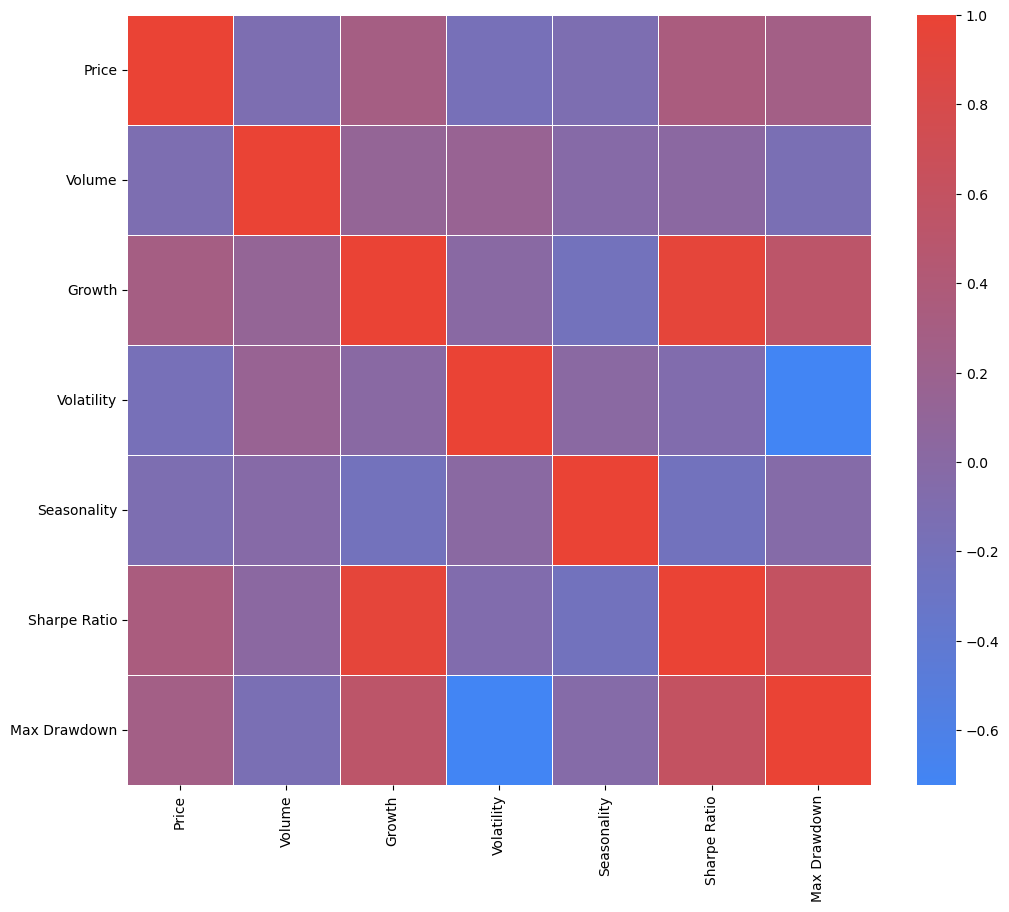

In [18]:
#@title Correlation for Characteristics

custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ['#4285f4', '#ea4335'])

corr_matrix = normalized_df.drop(columns=['Symbol']).corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap=custom_cmap,
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={"orientation": "vertical"}
)

plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)

ax = plt.gca()
ax.tick_params(axis='x', which='both', bottom=True, top=False)
ax.spines['top'].set_visible(False)

plt.show()

In [19]:
#@title Extract Characteristics for each Sector

sp500 = pd.read_csv("../Data/sp500.csv")
stocks_characteristics = stocks_characteristics.merge(sp500[["Symbol", "Sector"]], on="Symbol", how="left")

sectors_characteristics = stocks_characteristics.groupby("Sector").agg({
    "Price": "mean",
    "Volume": "mean",
    "Growth": "mean",
    "Volatility": "mean",
    "Seasonality": "mean",
    "Sharpe Ratio": "mean",
    "Max Drawdown": "mean"
}).reset_index()

sectors_characteristics.to_csv('../Data/sectors_characteristics.csv', index=False)

normalized_df_2 = sectors_characteristics.copy()
numeric_cols_2 = normalized_df_2.select_dtypes(include=["number"]).columns
scaler_2 = MinMaxScaler(feature_range=(0, 1))
normalized_df_2[numeric_cols] = scaler_2.fit_transform(normalized_df_2[numeric_cols])
normalized_df_2.to_csv('../Data/sectors_characteristics_norm.csv', index=False)

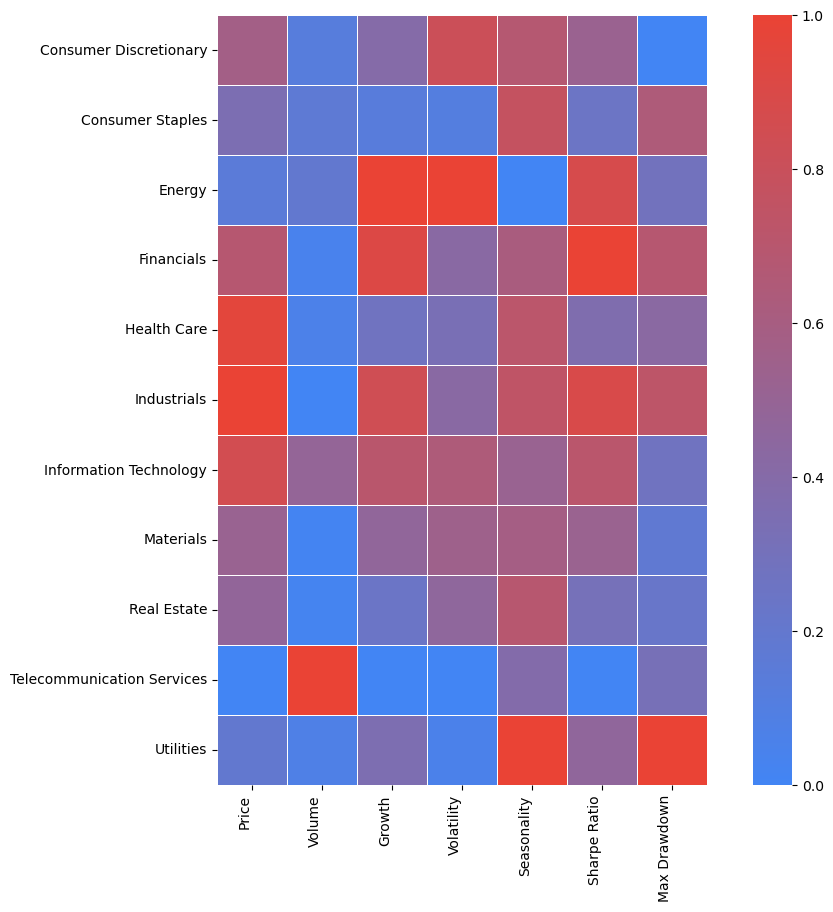

In [20]:
#@title Heatmap for Characteristics of Each Sector

custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ['#4285f4', '#ea4335'])

heatmap_df = normalized_df_2.drop(columns=['Sector']).set_index(normalized_df_2['Sector'])
heatmap_df.index.name = None

plt.figure(figsize=(12, 10))
sns.heatmap(
    heatmap_df,
    cmap=custom_cmap,
    cbar=True,
    linewidths=0.5,      
    linecolor='white',    
    annot=False,
    square=True           
)

plt.xticks(rotation=90, fontsize=10, ha='right')
plt.yticks(rotation=0, fontsize=10)

ax = plt.gca()
ax.tick_params(axis='x', which='both', bottom=True, top=False)
ax.spines['top'].set_visible(False)

plt.show()

In [21]:
#@title Split Data into Train/Test (80/20)

min_date = stock_data["Date"].min()
max_date = stock_data["Date"].max()
split_date = min_date + pd.Timedelta(days=int(0.8 * (max_date - min_date).days))
train_data = stock_data[stock_data['Date'] < split_date]
test_data = stock_data[stock_data['Date'] >= split_date]

In [22]:
#@title Save CSV Files

stock_data.to_csv('../Data/dataset4.csv', index=False)
train_data.to_csv('../train.csv', index=False)
test_data.to_csv('../Data/test.csv', index=False)